In [1]:
import gensim
import re
import math
import numpy as np
import pandas as pd
from nltk import ngrams
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
import csv
from collections import OrderedDict
import arabic_reshaper
from bidi.algorithm import get_display


In [2]:
#load all models
newspapers={"assafir":"assafir_models", "nahar":"nahar_models"}
directory="C:/Users/Ghumdan/Desktop/Jad/models/"
models={}

for n in newspapers:
    files=[]
    for f in os.listdir(directory+newspapers[n]):
        if f.endswith(".model"): 
            t_model=gensim.models.Word2Vec.load(directory+newspapers[n]+"/"+f)
            files.append({f:t_model.wv})
    
    models[n]=files
    

In [3]:
for n in models:
    models[n][0], models[n][1]=models[n][1], models[n][0]

In [4]:
for n in models:
    display(models[n])

[{'cbow_1974_2011.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbdbab1fd0>},
 {'cbow_1974_1983.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbd2d61d00>},
 {'cbow_1984_1993.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbeb594fd0>},
 {'cbow_1994_2003.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbe5a76130>},
 {'cbow_2004_2011.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbe8566fd0>}]

[{'cbow_1933_2009.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbda4fbfd0>},
 {'cbow_1933_1942.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbe76aafd0>},
 {'cbow_1943_1952.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bb9cd35fd0>},
 {'cbow_1953_1962.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bb9d4ab820>},
 {'cbow_1963_1972.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbe6966fd0>},
 {'cbow_1973_1982.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbe63ae2e0>},
 {'cbow_1983_1992.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bb97d360d0>},
 {'cbow_1993_2002.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bb9c206f10>},
 {'cbow_2003_2009.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bb99193fd0>}]

In [5]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!',"ة"]
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',"ه"]
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [6]:
def get_vocab(token,vectors):
    if token in vectors:
        return vectors.get_vecattr(token, "count") , vectors[token]
    else:
        return 0,np.zeros(300)

def get_count(token,vectors):
    if token in vectors:
        return vectors.get_vecattr(token, "count")
    else:
        return 0


def cos_sim(emb1, emb2):
    return np.dot(emb1,emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))


In [7]:
def gender_vector(pairs, vectors,n_components=1):
    N= len(pairs)

    mat= np.zeros((2*N,300),np.float64)
    for i in range(N):
        
        if(pairs[i][0] in vectors and pairs[i][1] in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[pairs[i][1]]
        elif(clean_str(pairs[i][0]) in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        elif(clean_str(pairs[i][0]) in vectors and pairs[i][1] in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[pairs[i][1]]
            
        elif(pairs[i][0] in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        center=(f_vector+m_vector)/2
        mat[2*i]=f_vector-center
        mat[2*i+1]=m_vector-center

      


    pca = PCA(n_components = n_components)
    mat2=pca.fit_transform(mat.transpose())
#     plt.bar(range(n_components), pca.explained_variance_ratio_)
    return  mat2.flatten()
    


In [8]:
def group_bias(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [9]:
def group_bias_details(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias_details(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [10]:
def getBias (male_words,female_words,vectors):
    
    biases=[]
    b=0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        biases.append(b)
    return biases
    

In [11]:
def word_bias(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
#     print(average," : ",male,"-",female)
#     average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [12]:
def word_bias_details(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
    print(average," : ",male,"-",female)
    # average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [13]:
#Horizontal
def plotBar(row,col,title,xLabel,yLabel,location):
    colors=['b','m','y','r']
    bias=['CorrectM',"CorrectF","Relatively Correct","Incorrect"]
    new_col = [ ]

    for item in col:
        new_col.append(get_display(arabic_reshaper.reshape(item)))
    # creating the bar plot
    y=np.arange(len(col))   
    x=row  

    plt.rcdefaults()
    fig, ax = plt.subplots()
    fig.set_figheight(4.5)
    fig.set_figwidth(9)
    barlist=ax.barh(y, x, align='center')
    for b in range(len(barlist)):
      if x[b] < 0:
        barlist[b].set_color(colors[0])
      elif x[b]==0:
        barlist[b].set_color(colors[2])
      else:
        barlist[b].set_color(colors[3])
    ax.set_yticks(y)
    ax.set_yticklabels(new_col)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    ma=max(x)
    mi=abs(min(x))
    lim=ma
    if ma < mi:
        lim=mi
    ax.set_xlim([-lim*1.2, lim*1.2])
    ax.set_title(title)
    ax.grid(color='grey', linestyle='dotted', linewidth=0.3)
    
    # fig.show()
    fig.savefig(location)


In [14]:
i=['صهيوني', 'إسرائيلي', 'الإسرائيليين', 'يهود', 'إسرائيل', 'أبيب', 'اليهود', 'شارون']
i.sort()

p=['المسلمين', 'الفلسطينيون', 'فلسطينيون', 'حماس', 'فلسطين', 'فلسطيني', 'التحرير', 'الفلسطينية']
p.sort()


nouns=list(zip(p, i))

# Categories

In [15]:
categories={}
#Occupation

Occupation=['تفتيش', 'إخلاء', 'مستوطنة', 'المستوطنين', 'مستوطن', 'احتل', 'هدم', 'احتلال', 'انفصال', 'الهدم', 'المستوطنات', 'عزل', 'سجناء', 'انسحاب', 'صاروخ', 'الهجمات', 'الصواريخ', 'قصف', 'انفجار', 'غارة']
Occupation.sort()
categories["Occupation"]={"male":Occupation,"female":Occupation}


#Resistance

Resistance =['معاناة', 'كفاح', 'نضال', 'صراع', 'تحمل', 'الصمود', 'المقاومة', 'صمود', 'التأقلم', 'المواجهة', 'تأقلم', 'مواجهة', 'مقاومة']
Resistance.sort()
categories["Resistance "]={"male":Resistance ,"female":Resistance}


#Violence

Violence=['الضربات', 'هجوم', 'أسلحة', 'اعتداء', 'ضربة', 'خرق', 'الجريمة', 'عنف', 'اضطهاد', 'مطرود', 'أذى', 'جريمة', 'بطش', 'قسوة']
Violence.sort()
# categories["Violence"]={"male":Violence,"female":Violence}


#Peace
Peace=["مسالم","سلام","السلمي","سلمي","امن","أمان","هادئ","هدوء","سكون","سلمية"]
Peace.sort()
categories["Peace"]={"male":Peace,"female":Peace}


#Terrorism

Terrorism=['مذبحة', 'جناية', 'جريمة', 'القتل', 'الإعدام', 'إرهابيين', 'الإرهاب', 'الرصاص', 'إراقة', 'إرهاب', 'إرهابي', 'الذبح', 'محاكمة']
Terrorism.sort()
vt=Violence+Terrorism
categories["V&T"]={"male":vt,"female":vt}

#Validation
len(categories)

for c in categories:
    if len(categories[c]["male"]) != len(categories[c]["female"]): 
                                               print(c)

# Running Bias Test

In [16]:
dataframes={}
for n in models:
    newspaper=n
    df = pd.DataFrame(columns = ['Years']+list(categories.keys()))
    for model in models[n]:
        
        for m in model:
            
            date=m[5:-6]
            vectors=model[m]
            row=[]
            row.append(date)
            g=gender_vector(nouns,vectors)
            for c in categories:
                bias=group_bias(g,categories[c]["male"],categories[c]["female"],vectors)
                row.append(bias)
#                 print(n,m,c,bias)
#             print("-----------------------------------")
            df.loc[len(df.index)]=row
        
    dataframes[n]=df


In [17]:

for d in dataframes:
    print(d)
    display(dataframes[d])

assafir


,Years,Occupation,Resistance,Peace,V&T
0,1974_2011,0.047652,-0.139974,-0.033410,0.011086
1,1974_1983,-0.066604,0.122953,0.016402,-0.013919
2,1984_1993,0.039063,-0.132831,-0.035396,0.007968
3,1994_2003,0.025091,-0.126861,-0.019278,0.029250
4,2004_2011,0.037650,-0.107308,-0.045171,0.008999


nahar


,Years,Occupation,Resistance,Peace,V&T
0,1933_2009,0.049673,-0.148748,-0.058847,0.021253
1,1933_1942,0.023016,-0.000756,0.002670,0.024448
2,1943_1952,0.032357,-0.010615,0.000979,0.027837
3,1953_1962,0.013183,0.063328,-0.001401,0.004464
4,1963_1972,0.004899,0.101832,-0.009805,-0.009960
5,1973_1982,0.042147,-0.126864,-0.002789,0.010252
6,1983_1992,-0.055624,0.142720,0.051578,-0.018807
7,1993_2002,0.039513,-0.139132,-0.058027,0.014902
8,2003_2009,0.046559,-0.098293,-0.038834,0.021223


In [18]:
for d in dataframes:
    print(d)
    display(dataframes[d].iloc[[0]])

assafir


,Years,Occupation,Resistance,Peace,V&T
0,1974_2011,0.047652,-0.139974,-0.03341,0.011086


nahar


,Years,Occupation,Resistance,Peace,V&T
0,1933_2009,0.049673,-0.148748,-0.058847,0.021253


In [19]:
writer = pd.ExcelWriter("politics/political_results.xlsx", engine='xlsxwriter')

for df in dataframes:
    dataframes[df].to_excel(writer, sheet_name=df, startrow=0, header=True, index=False)
writer.save()


# Results

In [20]:
main_models={}
main_models_names={"cbow_1974_2011.model",'cbow_1950_2000.model','cbow_1933_2009.model'}
for n in models:
     for model in models[n]:
            for m in model:
                if m in main_models_names:
                    main_models[n+'-'+m]=model[m]
display(main_models)

{'assafir-cbow_1974_2011.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbdbab1fd0>,
 'nahar-cbow_1933_2009.model': <gensim.models.keyedvectors.KeyedVectors at 0x1bbda4fbfd0>}

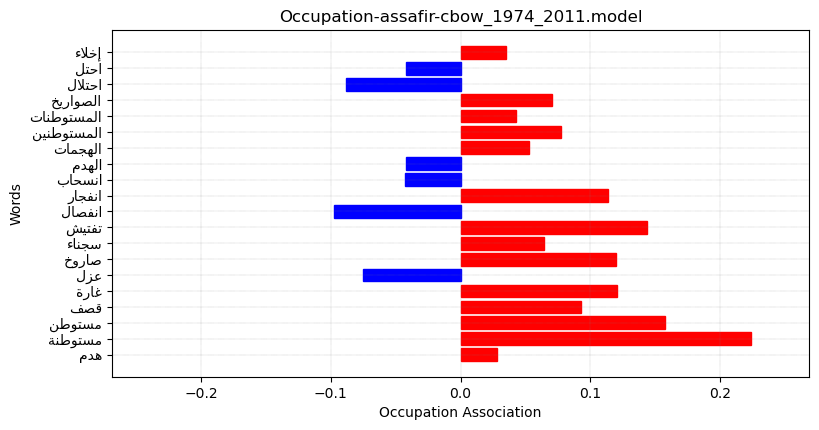

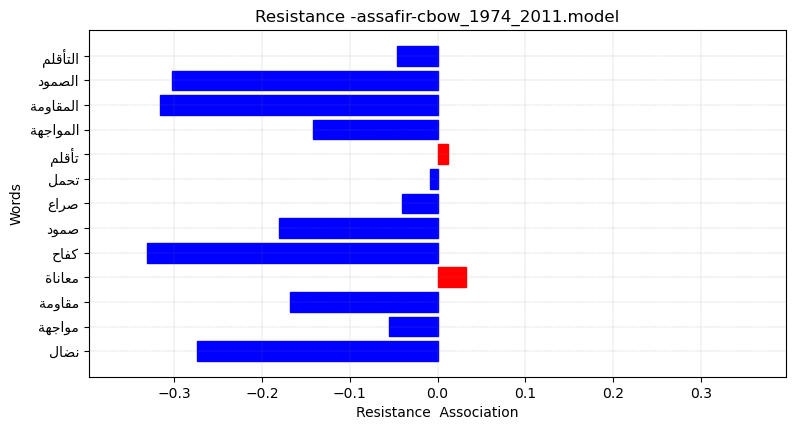

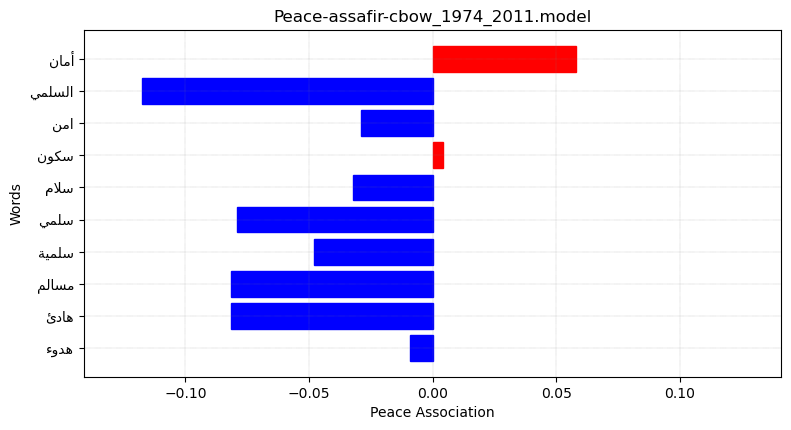

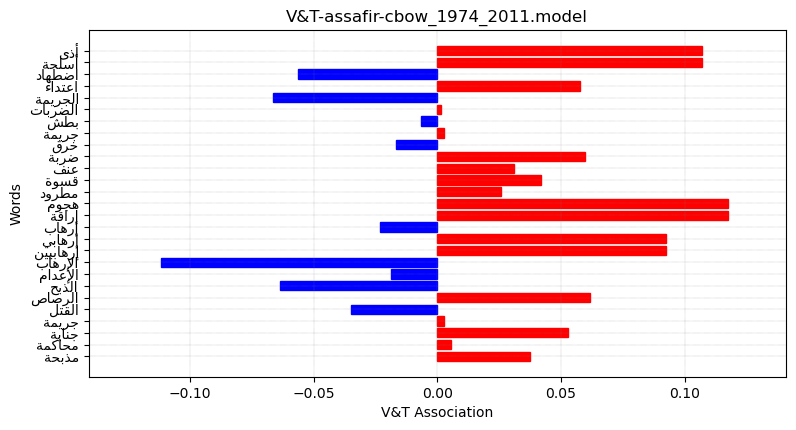

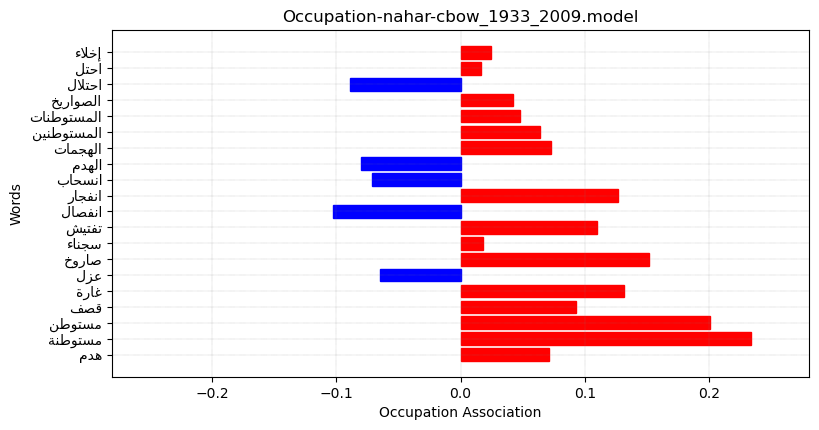

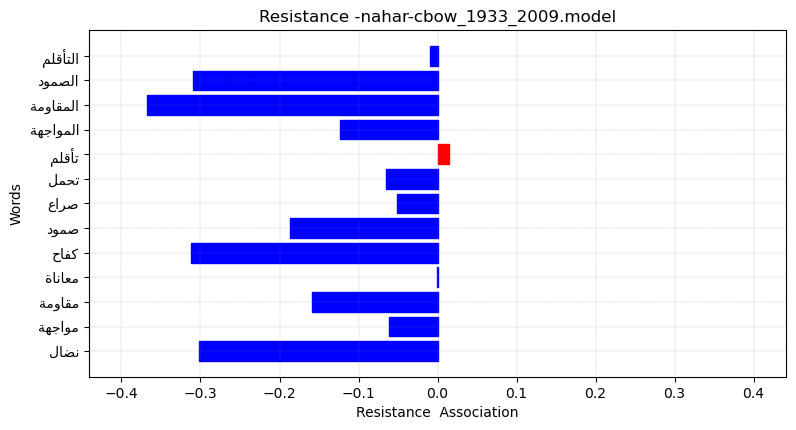

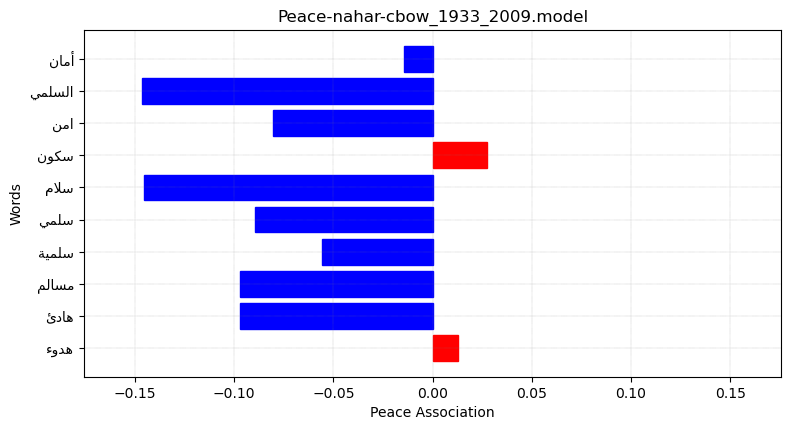

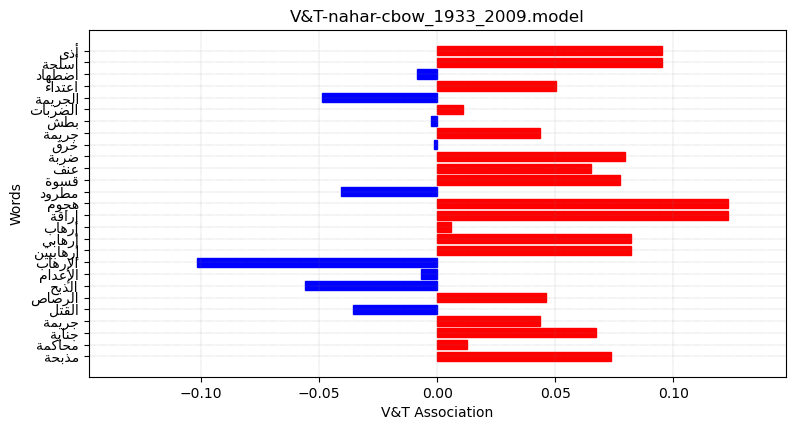

In [21]:
#By Category
for m in main_models:

        vectors=main_models[m]
        g=gender_vector(nouns,vectors)
        for c in categories:
            location="politics/byCategory/"+c+'-'+m+'.png'
            plotBar(getBias(categories[c]['male'],categories[c]['female'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",location)
           


           


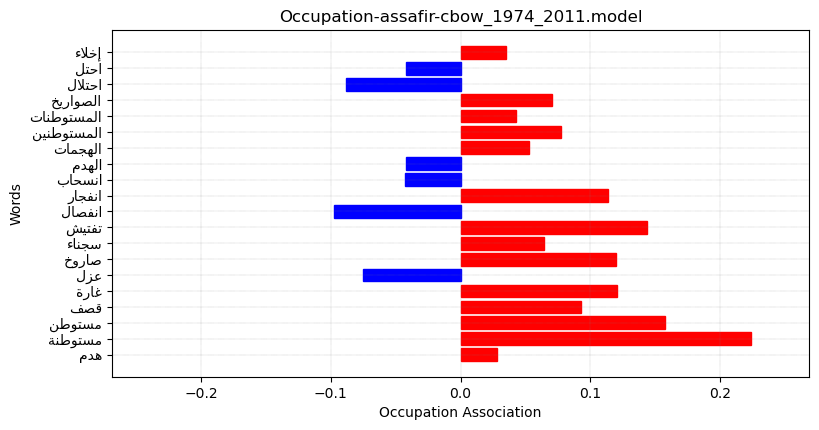

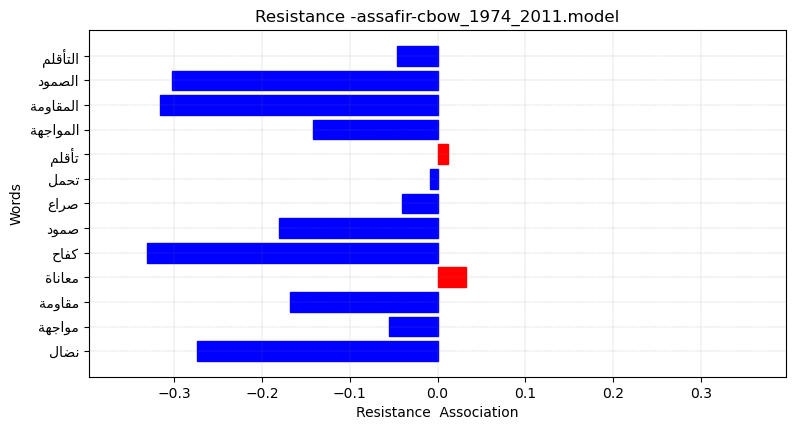

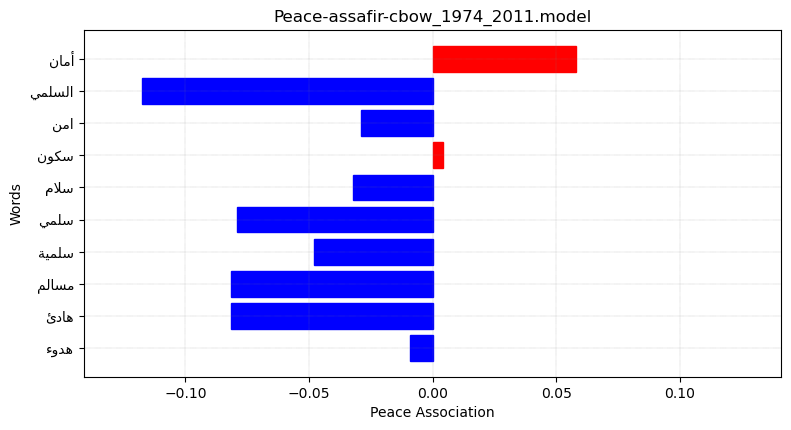

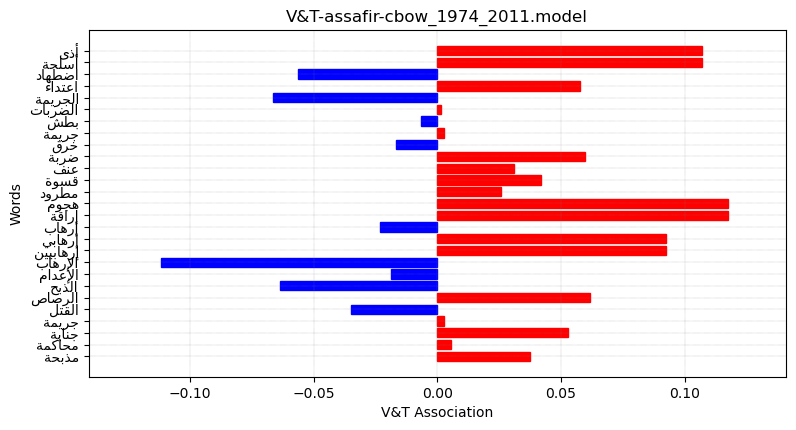

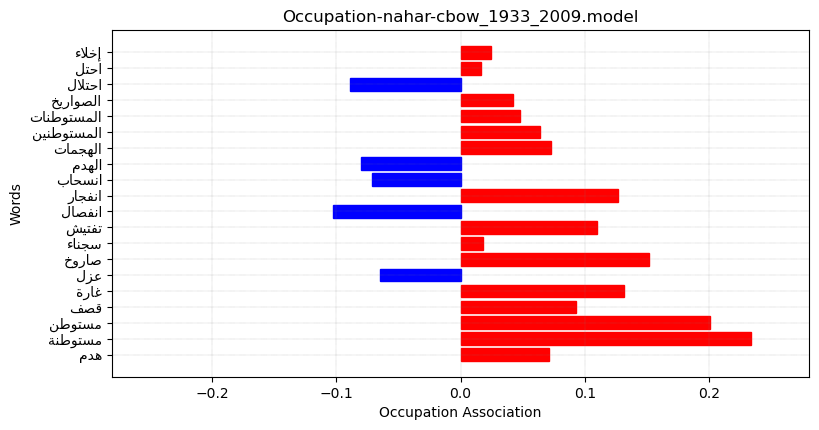

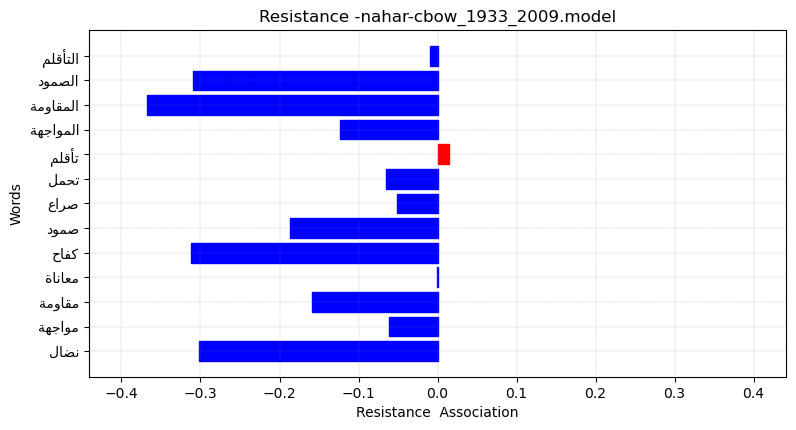

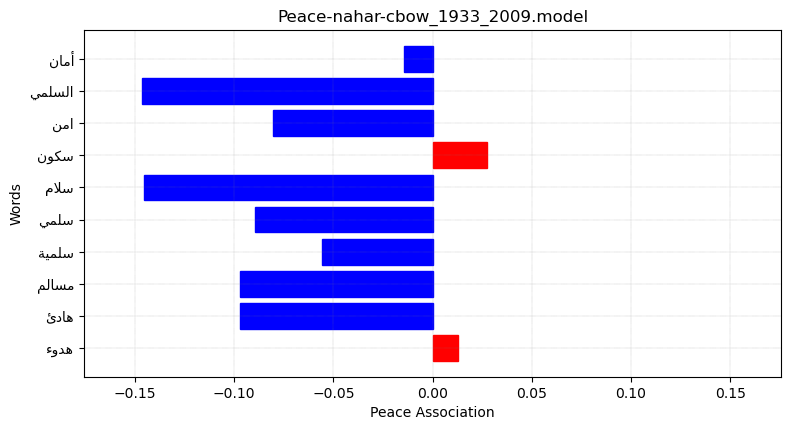

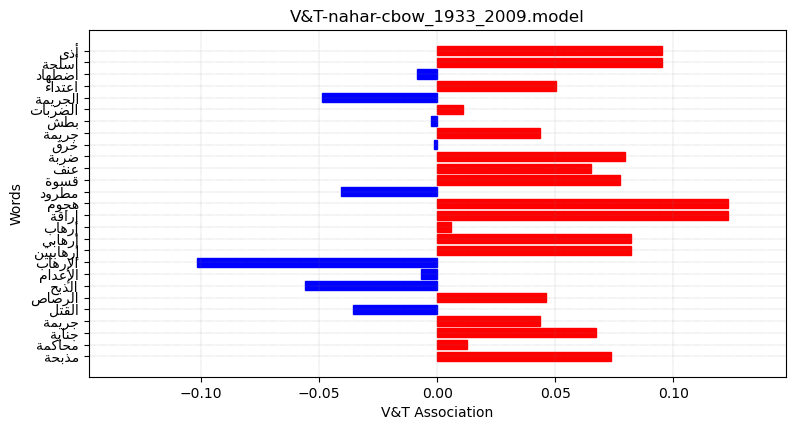

In [22]:
##By newspaper

for m in main_models:

    vectors=main_models[m]
    g=gender_vector(nouns,vectors)
    for c in categories:
        nn=m.split('-')
        location="politics/byNewspaper/"+nn[0]+'-'+c+'-'+nn[1]+'.png'
        plotBar(getBias(categories[c]['male'],categories[c]['female'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",location)

In [23]:
dfs = pd.read_excel("politics/political_results.xlsx", sheet_name=None)

In [24]:
cats=list(dfs["nahar"].columns)[1:]

newcats=cats

print(newcats)

['Occupation', 'Resistance ', 'Peace', 'V&T']


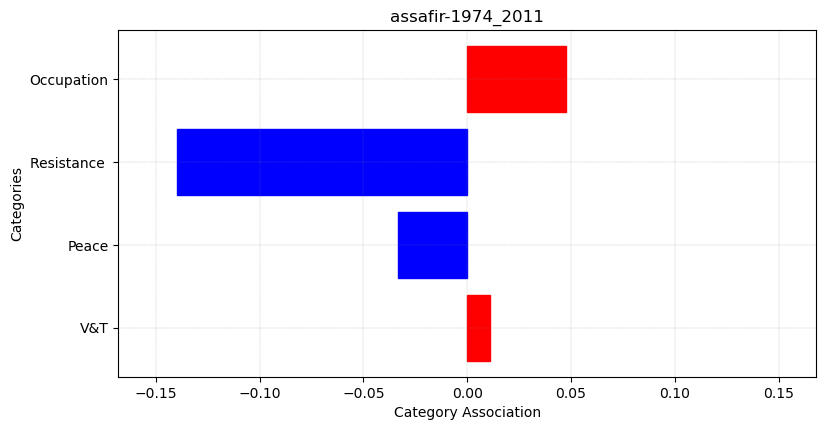

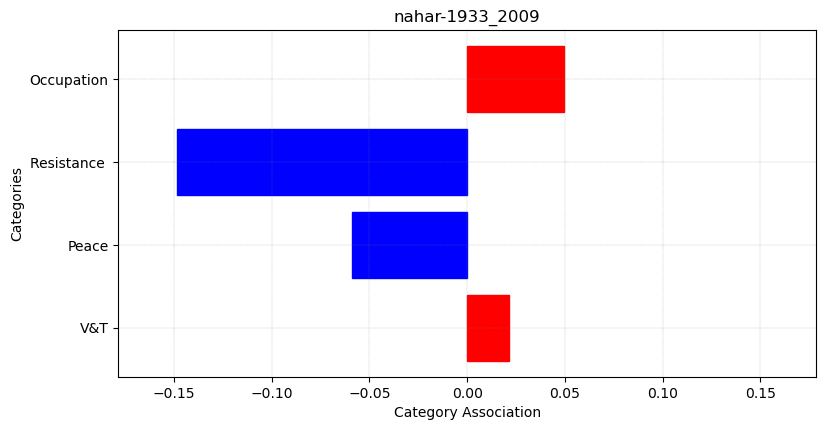

In [25]:
for d in dfs:
    row=list(dfs[d].iloc[0])
    plotBar(row[1:],cats,d+'-'+row[0],"Category Association","Categories",'politics/'+d+'-'+row[0]+'.png')


In [27]:
years=list(dfs['nahar']['Years'][1:])
years=[ x[2:4]+'-'+x[-2:] for x in years ]
print(years)

['33-42', '43-52', '53-62', '63-72', '73-82', '83-92', '93-02', '03-09']


In [31]:
dfs2={'assafir':dfs['assafir'][1:],'nahar':dfs['nahar'][1:]}

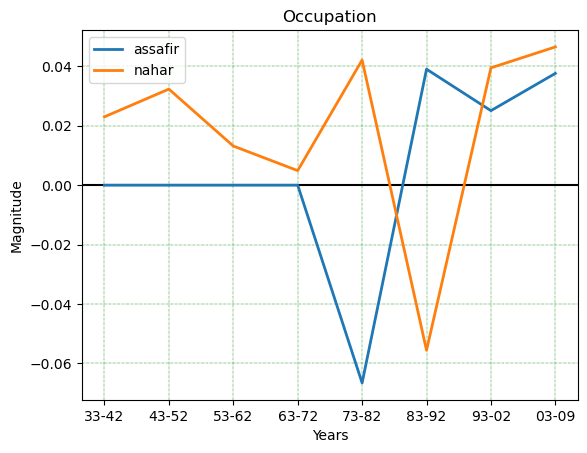

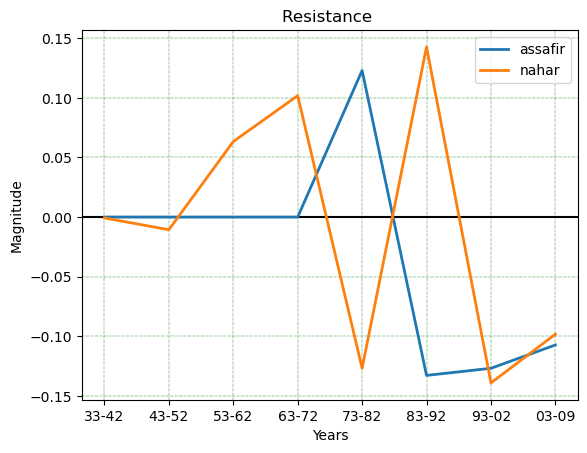

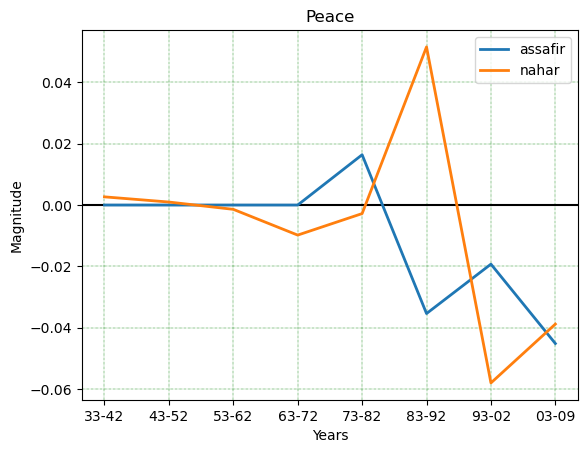

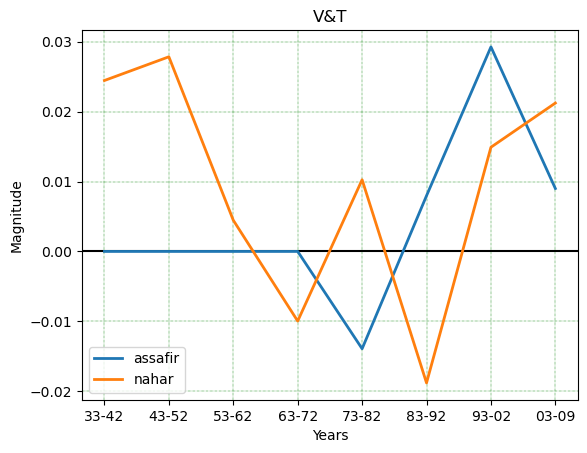

In [32]:
for c in range(int(len(cats))):
    
    plt.figure()
    xpoints = years
    #plt.figure(figsize=(9, 3), dpi=80)
    plt.axhline(y=0, color='black')
    
    plt.plot(xpoints,  [0,0,0,0]+list(dfs2['assafir'][cats[c]]),  label='assafir',linewidth=2)
    plt.plot(xpoints,  dfs2['nahar'][cats[c]],  label='nahar',linewidth=2)

    plt.title(cats[c])
    plt.xlabel("Years")
    plt.ylabel("Magnitude")
    plt.grid(color = 'green', linestyle = '-.', linewidth = 0.3)
    plt.legend()
    plt.savefig('politics/temporal/'+cats[c]+'.png')
